In [1]:
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/pbs/home/c/cmurray/cluster_likelihood/modules/sbi/')
import simulation
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import corner
import pickle
import scipy.stats as stats
from matplotlib.cm import get_cmap
import pickle
import pyccl as ccl
sys.path.append('/pbs/home/c/cmurray/cluster_likelihood/pinocchio/')
import pinocchio_binning_scheme as binning_scheme
def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

/pbs/home/c/cmurray/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Create capish simulators

In [67]:
stacked_simulator_pl = simulation.Universe_simulation( 'stacked_counts' ,
                                                        variable_params=['omega_m', 
                                                                         'sigma_8', 
                                                                         'h',
                                                                         'alpha' , 
                                                                         'c' , 
                                                                         'beta',
                                                                         'sigma' ],
                                                        fixed_params={'w_0': -1, 'w_a': 0 } )

stacked_simulator_pl.selection_richness = 0
def dOmega_z(z):
    return 0.25 * 4 * np.pi
stacked_simulator_pl.dOmega = dOmega_z
stacked_simulator_pl.richness_bins = np.logspace( np.log10( 0.1 ) , np.log10( 300 ) , 12 )
stacked_simulator_pl.redshift_bins = np.array( [ 0.2 , 0.35 , 0.5 , 0.65 ])
stacked_simulator_pl.sigma_mwl = 0#0.25
stacked_simulator_pl.include_mwl_measurement_errors = False
#stacked_simulator_pl.mwl_std = mwl_std
stacked_simulator_pl.correlation_mass_evolution = False
#stacked_simulator_pl.set_richness_mass_relation( 'power law' )
stacked_simulator_pl.set_richness_mass_relation( 'constantins model' )
stacked_simulator_pl.set_bins( z_bins = np.arange( 0.2 , 1 , 0.001 ) , 
                               log10m_bins=  np.arange( 14.2 , 15.5 , 0.001))
massdef = ccl.halos.massdef.MassDef('vir', 'critical',)
hmd = ccl.halos.hmfunc.MassFuncDespali16( mass_def=massdef)
stacked_simulator_pl.hmf = ccl.halos.MassFuncDespali16(mass_def=massdef)
stacked_simulator_pl.use_hybrid = False
stacked_simulator_pl.add = False

In [68]:
sim_obs = stacked_simulator_pl.run_simulation(torch.Tensor([ 0.30711 , 0.8288 , 0.6777 , 2.3 , 3.2, 0 , 0.5 ]))

0.3071100115776062 0.048254 0.6776999831199646 0.8288000226020813


AttributeError: 'Universe_simulation' object has no attribute 'add_SSC'

In [53]:
def dOmega_z_func( z ):
    return 0.25 * 4 * np.pi

In [60]:
stacked_simulator = simulation.Universe_simulation( 'des_stacked_counts' ,
                                                    variable_params=['omega_m', 
                                                                     'sigma_8', 
                                                                     'h',
                                                                     'alpha' , 
                                                                     'B' ,
                                                                     'log10Mmin',
                                                                     'beta',
                                                                     'sigma',
                                                                     'r'],
                                                    fixed_params={'w_0': -1, 'w_a': 0 } )
stacked_simulator.selection_richness = 0
stacked_simulator.dOmega = dOmega_z_func
stacked_simulator.richness_bins = np.logspace( np.log10( 0.1 ) , np.log10( 300 ) , 12 )
stacked_simulator.redshift_bins = np.array( [ 0.2 , 0.35 , 0.5 , 0.65 ])
stacked_simulator.sigma_mwl = 0.25
stacked_simulator.include_mwl_measurement_errors = False
# measure errors for weak lensing masses
stacked_simulator.mwl_std = 0.3
stacked_simulator.correlation_mass_evolution = False
stacked_simulator.set_richness_mass_relation( 'halo model' )
stacked_simulator.massdef = ccl.halos.massdef.MassDef('200', 'matter',)
stacked_simulator.halobias_fct = ccl.halos.hbias.tinker10.HaloBiasTinker10(mass_def=stacked_simulator.massdef)
# set the Aemulus correction to the halo mass function
stacked_simulator.s = 0.037
stacked_simulator.q = 1.008

stacked_simulator.set_bins( z_bins = np.arange( 0.2 , 1 , 0.001 ) , 
                               log10m_bins=  np.arange( 13.5 , 15.5 , 0.001))

stacked_simulator.hmf = ccl.halos.hmfunc.MassFuncTinker08( mass_def ='200m')
stacked_simulator.Z_edges_hybrid = binning_scheme.redshift_edges
Z_bin_hybrid = [[stacked_simulator.Z_edges_hybrid[i], stacked_simulator.Z_edges_hybrid[i+1]] for i in range(len(stacked_simulator.Z_edges_hybrid)-1)]
stacked_simulator.poisson_only = True
stacked_simulator.use_hybrid = False

stacked_simulator.f_sky = 1

# set the binning used to simulate a cluster catalogue
stacked_simulator.set_bins( z_bins = np.arange( 0.15 , 0.7 , 0.05 ) , log10m_bins =  np.arange( 13.1, 16 , 0.01))

stacked_simulator.add_SSC = False

In [61]:
S_ij_full_sky = load(f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/S_ij_full_sky.pkl' )
stacked_simulator.Sij_SSC = S_ij_full_sky/stacked_simulator.f_sky

sigma_ij_full_sky = load(f'/pbs/throng/lsst/users/cpayerne/capish/data/pinocchio_matrix/sigma_ij_full_sky.pkl' )
stacked_simulator.sigmaij_SSC = sigma_ij_full_sky/stacked_simulator.f_sky

# Counts for different cosmologies

In [62]:
sim_obs = stacked_simulator.run_simulation( torch.Tensor( [ 0.3,
                                                             0.85,
                                                             0.744,
                                                             0.748 - np.log10(0.744),
                                                             np.log10( 10**12.37 / 10**11.13 ),
                                                             11.13,
                                                             0.0,
                                                             0.31301698088645935, 
                                                             0 ] ))

0.30000001192092896 0.048254 0.7440000176429749 0.8500000238418579


In [63]:
sim_obs_eds = stacked_simulator.run_simulation( torch.Tensor( [ 1,
                                                             0.85,
                                                             0.744,
                                                             0.748 - np.log10(0.744),
                                                             np.log10( 10**12.37 / 10**11.13 ),
                                                             11.13,
                                                             0.0,
                                                             0.31301698088645935, 
                                                             0 ] ))

1.0 0.048254 0.7440000176429749 0.8500000238418579


In [64]:
sim_obs_eds

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [59]:
sim_n_clusters = sim_obs[:33].reshape(11, 3)
sim_mwl_mean = sim_obs[33:].reshape(11, 3)

sim_n_clusters_high_om = sim_obs_eds[:33].reshape(11, 3)
sim_mwl_mean_high_om = sim_obs_eds[33:].reshape(11, 3)

In [45]:
lambda_cents = ( np.logspace( np.log10( 10 ) , np.log10( 300 ) , 12 )[1:] + np.logspace( np.log10( 10 ) , np.log10( 300 ) , 12 )[:-1] ) /2.

In [46]:
sim_n_clusters_high_om

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [31]:
sim_n_clusters

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

/tmp/ipykernel_11269/3148490325.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


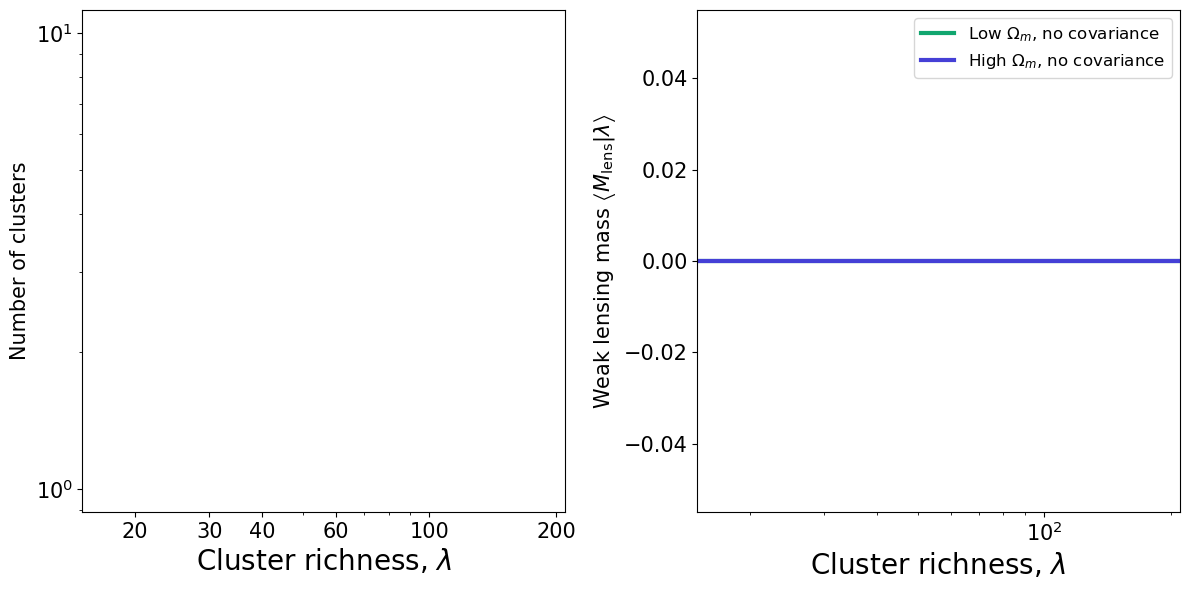

In [21]:
plt.figure( figsize = ( 12 , 6 ))
plt.subplot( 121 )
plt.plot( lambda_cents , sim_n_clusters.T[0] , lw = 3 , color ='#11a66f' ) #, drawstyle='steps-mid')
plt.plot( lambda_cents , sim_n_clusters_high_om.T[0] , lw = 3 , color ='#4540d6' ) # , drawstyle='steps-mid')
plt.xlabel(r'Cluster richness, $\lambda$' , fontsize = 20)
plt.ylabel(r'Number of clusters' , fontsize = 15)
plt.xscale('log')
plt.yscale('log')
# plt.xlim( 13 , 15.3 )

# # plt.ylim( 2 , 110 )
plt.yticks( fontsize = 15 )
plt.xticks( ticks = [ 20 , 30 , 40 , 60 , 100 , 200 ],
            labels = [ 20 , 30 , 40 , 60 , 100 , 200  ] , fontsize = 15 )

plt.xlim( 15 , 210 )
plt.subplot( 122 )
plt.plot( lambda_cents , sim_mwl_mean.T[0] , lw = 3 , color ='#11a66f' , label = r'Low $\Omega_m$, no covariance')
plt.plot( lambda_cents , sim_mwl_mean_high_om.T[0] , lw = 3 , color ='#4540d6', label = r'High $\Omega_m$, no covariance' )
plt.xlabel(r'Cluster richness, $\lambda$' , fontsize = 20)
plt.ylabel(r'Weak lensing mass $\left< M_{ \rm{lens} } | \lambda \right>$' , fontsize = 15)


plt.yticks( fontsize = 15 )
plt.xticks( ticks = [ 20 , 30 , 40 , 60 , 100 , 200 ],
            labels = [ 20 , 30 , 40 , 60 , 100 , 200  ] , fontsize = 15 )
plt.xlim( 15 , 210 )
plt.xscale('log')
plt.legend(fontsize = 12 )
plt.tight_layout()

# Posteriors with and without mass-scaling.